### Model Selection and Model Building

##### Data Preprocessing and EDA

In [64]:
# Import the necessary libraries

import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy.stats import boxcox
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [65]:
# Reading the excel dataset

health_df = pd.read_excel('Healthcare_dataset.xlsx', sheet_name = 'Dataset')

In [66]:
health_df.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1


In [4]:
health_info = pd.read_excel('Healthcare_dataset.xlsx')
# health_info

In [59]:
# health_df.info()

In [68]:
# Shape of the dataset

print(("rows, Columns"),health_df.shape)

rows, Columns (3424, 69)


In [8]:
# Checking for numbers of unique values in each of the column

health_df.nunique()

Ptid                              3424
Persistency_Flag                     2
Gender                               2
Race                                 4
Ethnicity                            3
                                  ... 
Risk_Hysterectomy_Oophorectomy       2
Risk_Estrogen_Deficiency             2
Risk_Immobilization                  2
Risk_Recurring_Falls                 2
Count_Of_Risks                       8
Length: 69, dtype: int64

In [69]:
# dropping the id column
health_df.drop(['Ptid'], axis=1, inplace=True)

In [70]:
# Numbers of different types of variable

# Categorical features
categorical_cols =  health_df.select_dtypes(include=['object']).columns
print("Categorical columns  =", len(categorical_cols))

# Numerical features
numerical_cols = list(health_df.select_dtypes(include=['int64']).columns)
print("Numrical columns =", len(numerical_cols))
numerical_cols

Categorical columns  = 66
Numrical columns = 2


['Dexa_Freq_During_Rx', 'Count_Of_Risks']

In [11]:
health_df[numerical_cols].describe()

,Dexa_Freq_During_Rx,Count_Of_Risks
count,3424.000000,3424.000000
mean,3.016063,1.239486
std,8.136545,1.094914
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,3.000000,2.000000
max,146.000000,7.000000


Identifying missing values

In [71]:
# In the  dataframe, the null/missing values were captured as unknown, hence the need for transformation

# Replacing the unknown values with NAN
health_df = health_df.replace('Unknown', np.nan)
health_df = health_df.replace('Other/Unknown', np.nan)
health_df.head(3)

,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,N,N,N,N,N,N,N,N,0
1,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,N,N,N,N,N,N,N,N,0
2,Non-Persistent,Female,NaN,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,Y,N,N,N,N,N,N,N,2


In [72]:
# Checking for the categorical columns with missing values

categorical_cols_with_nan = health_df.select_dtypes(include='object').columns[health_df.select_dtypes(include='object').isnull().any()]
categorical_cols_with_nan

Index(['Race', 'Ethnicity', 'Region', 'Ntm_Speciality',
       'Risk_Segment_During_Rx', 'Tscore_Bucket_During_Rx', 'Change_T_Score',
       'Change_Risk_Segment'],
      dtype='object')

In [73]:
# Viweing the first 5 rows of cloumns with missing values

health_df[categorical_cols_with_nan].head()

,Race,Ethnicity,Region,Ntm_Speciality,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment
0,Caucasian,Not Hispanic,West,GENERAL PRACTITIONER,VLR_LR,<=-2.5,No change,NaN
1,Asian,Not Hispanic,West,GENERAL PRACTITIONER,NaN,NaN,NaN,NaN
2,NaN,Hispanic,Midwest,GENERAL PRACTITIONER,HR_VHR,<=-2.5,No change,No change
3,Caucasian,Not Hispanic,Midwest,GENERAL PRACTITIONER,HR_VHR,<=-2.5,No change,No change
4,Caucasian,Not Hispanic,Midwest,GENERAL PRACTITIONER,NaN,NaN,NaN,NaN


In [74]:
# Checking percentage of observations with missing values per column

health_df_nan = health_df[categorical_cols_with_nan].isnull().mean()

health_df_nan = pd.DataFrame(health_df_nan.reset_index()) # Convert array into a dataframe
health_df_nan.columns = ['Variable', 'Missing_percentage'] # Add column names to the dataframe

# Sorting the dataframe in descending order of missing values.
health_df_nan == health_df_nan.sort_values(by='Missing_percentage', ascending=False, inplace=True)

health_df_nan

,Variable,Missing_percentage
7,Change_Risk_Segment,0.650993
4,Risk_Segment_During_Rx,0.437208
5,Tscore_Bucket_During_Rx,0.437208
6,Change_T_Score,0.437208
3,Ntm_Speciality,0.090537
0,Race,0.028329
1,Ethnicity,0.026577
2,Region,0.017523


Race                         97
Ethnicity                    91
Region                       60
Ntm_Speciality              310
Risk_Segment_During_Rx     1497
Tscore_Bucket_During_Rx    1497
Change_T_Score             1497
Change_Risk_Segment        2229
dtype: int64


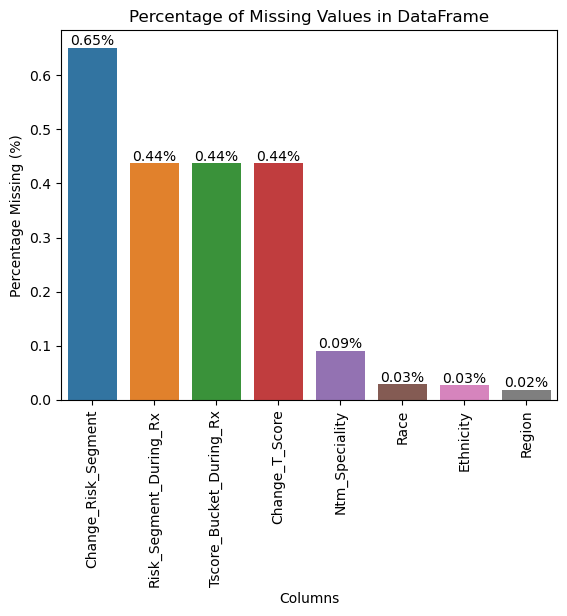

In [77]:
# Proportion of missing values in categorical columns
print(health_df[categorical_cols_with_nan].isnull().sum())

# Plotting the percentage OF missing values on a bar chart

sns.barplot(x='Variable', y='Missing_percentage', data=health_df_nan)
plt.title('Percentage of Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing (%)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed


# Iterate over index positions and rows to add missing percentages to the bars
for i, (index, row) in enumerate(health_df_nan.iterrows()):
    plt.text(i, row['Missing_percentage'], f"{row['Missing_percentage']:.2f}%", 
             horizontalalignment='center', verticalalignment='bottom', fontsize=10)

#### Handling missing values

In [79]:
# Using Mode Imputation Method
# Impute missing values with mode for each categorical column

for col in categorical_cols_with_nan:
    mode_value = health_df[col].mode()[0]  # Calculate mode for the column
    health_df[col].fillna(mode_value, inplace=True)  # Fill missing values with mode
    
# Checking for missing values after mode imputation

print(health_df[categorical_cols_with_nan].isnull().sum())

health_df.head(3)

Race                       0
Ethnicity                  0
Region                     0
Ntm_Speciality             0
Risk_Segment_During_Rx     0
Tscore_Bucket_During_Rx    0
Change_T_Score             0
Change_Risk_Segment        0
dtype: int64


,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,N,N,N,N,N,N,N,N,0
1,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,N,N,N,N,N,N,N,N,0
2,Non-Persistent,Female,Caucasian,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,Y,N,N,N,N,N,N,N,2


##### Identifying and Handling Outliers and Skewness in Numerical faetures

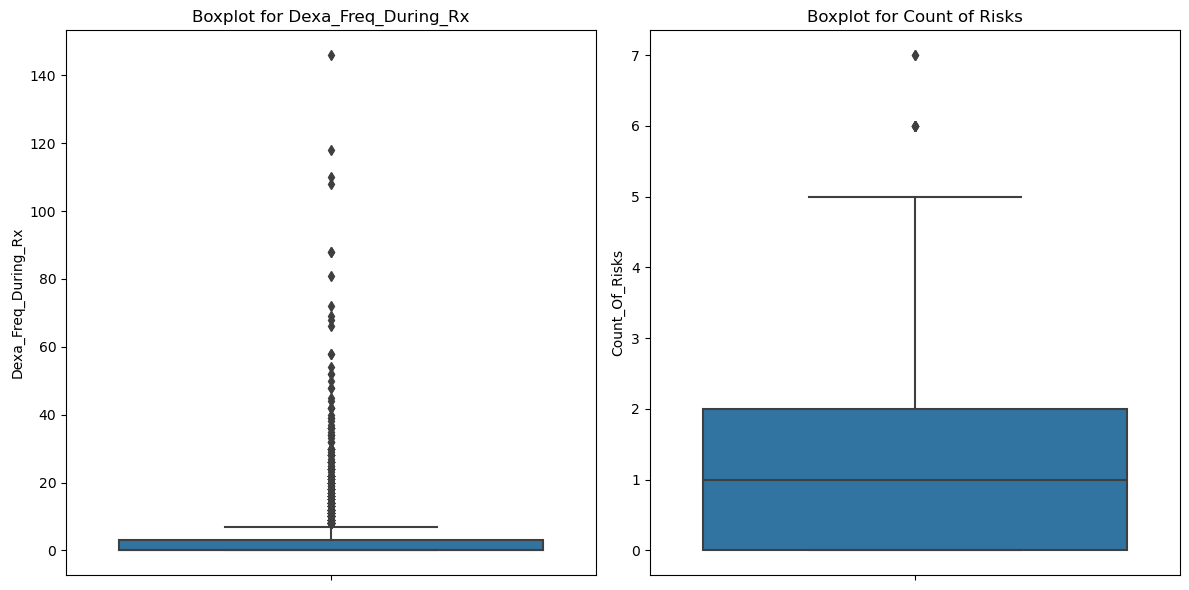

In [80]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for 'Dexa_Freq_Level'
sns.boxplot(y=health_df['Dexa_Freq_During_Rx'], ax=axes[0])
axes[0].set_title('Boxplot for Dexa_Freq_During_Rx')
axes[0].set_ylabel('Dexa_Freq_During_Rx')

# Boxplot for 'Risk_Level'
sns.boxplot(y=health_df['Count_Of_Risks'], ax=axes[1])
axes[1].set_title('Boxplot for Count of Risks')
axes[1].set_ylabel('Count_Of_Risks')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Dexa_Freq_During_Rx and Count_of_Risk have some numbers of outliers

Skewness of each numerical variable before transformation:
Dexa_Freq_During_Rx    6.808730
Count_Of_Risks         0.879791
dtype: float64


<Figure size 1000x600 with 0 Axes>

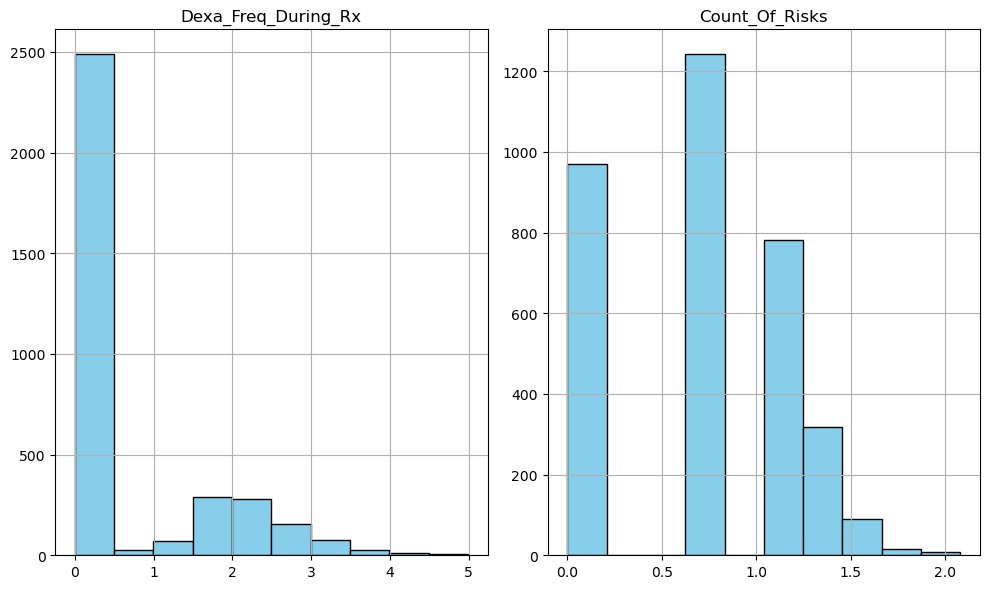

In [81]:
# identifying Skewness in the numerical columns

numerical_cols = health_df.select_dtypes(include=['int64', 'float64']).columns

# Skewness for numerical columns
skewness = health_df[numerical_cols].skew()
print("Skewness of each numerical variable before transformation:")
print(skewness)

# Histogram of the skewed numerical features

plt.figure(figsize=(10, 6))
health_df1.hist(color='skyblue', edgecolor='black', figsize=(10, 6))
plt.tight_layout()  
plt.show()

Skewness of each numerical variable after transformation:
Dexa_Freq_During_Rx    1.405860
Count_Of_Risks        -0.091583
dtype: float64


<Figure size 1000x600 with 0 Axes>

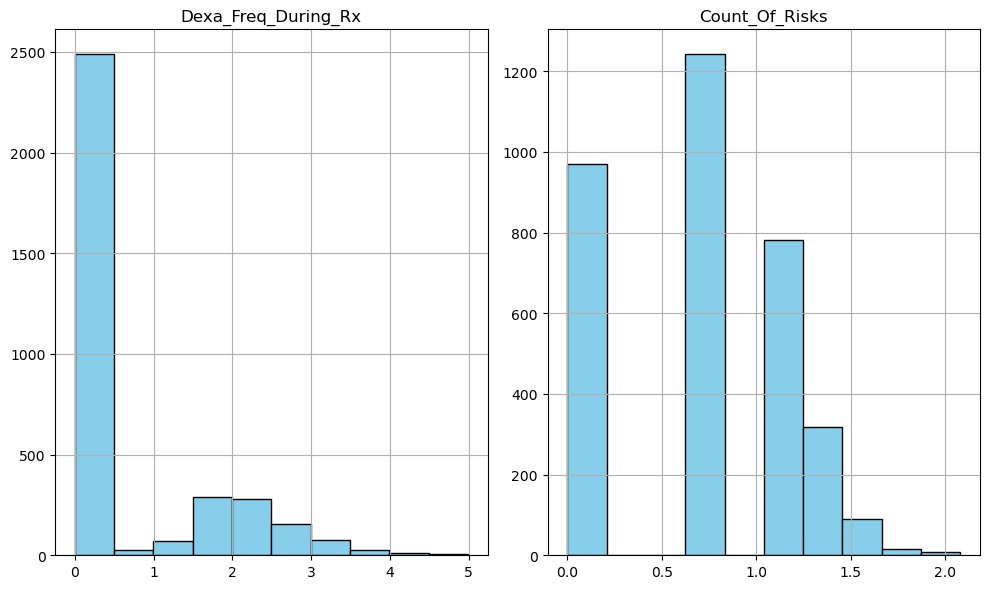

In [82]:
# Applying log transformation to address the skeweness

skewed_features = skewness[abs(skewness) > 0.5].index
health_df[skewed_features] = np.log1p(health_df[skewed_features])

# Skewness after log transformation
skewness_after = health_df[skewed_features].skew()
print("Skewness of each numerical variable after transformation:")
print(skewness_after)

#Histogram after transformation

plt.figure(figsize=(10, 6))
health_df.hist(color='skyblue', edgecolor='black', figsize=(10, 6))
plt.tight_layout()  
plt.show()

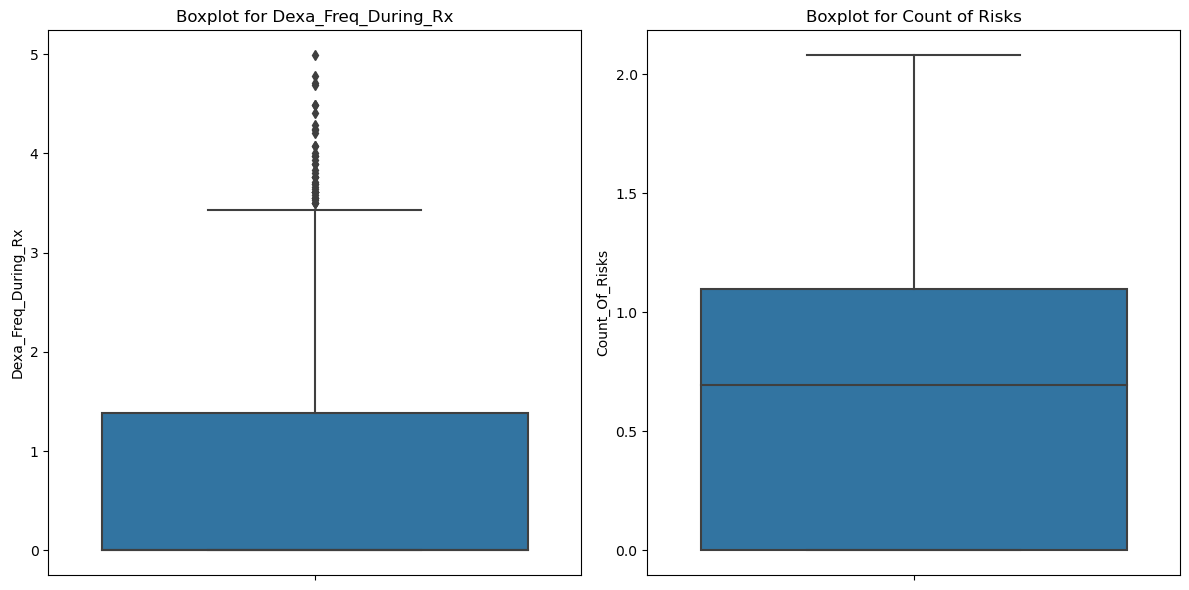

In [83]:
# Checking the ouliers after addressing the skewness

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for 'Dexa_Freq_Level'
sns.boxplot(y=health_df['Dexa_Freq_During_Rx'], ax=axes[0])
axes[0].set_title('Boxplot for Dexa_Freq_During_Rx')
axes[0].set_ylabel('Dexa_Freq_During_Rx')

# Boxplot for 'Risk_Level'
sns.boxplot(y=health_df['Count_Of_Risks'], ax=axes[1])
axes[1].set_title('Boxplot for Count of Risks')
axes[1].set_ylabel('Count_Of_Risks')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

After addressing the skwewness, the outlies appears to have become addressed in  the count_of_risk and got reduced in Dexa_Freq_During_Rx

 Addressing the outliers in Dexa_Freq_During_Rx futher using cox box transfgormation

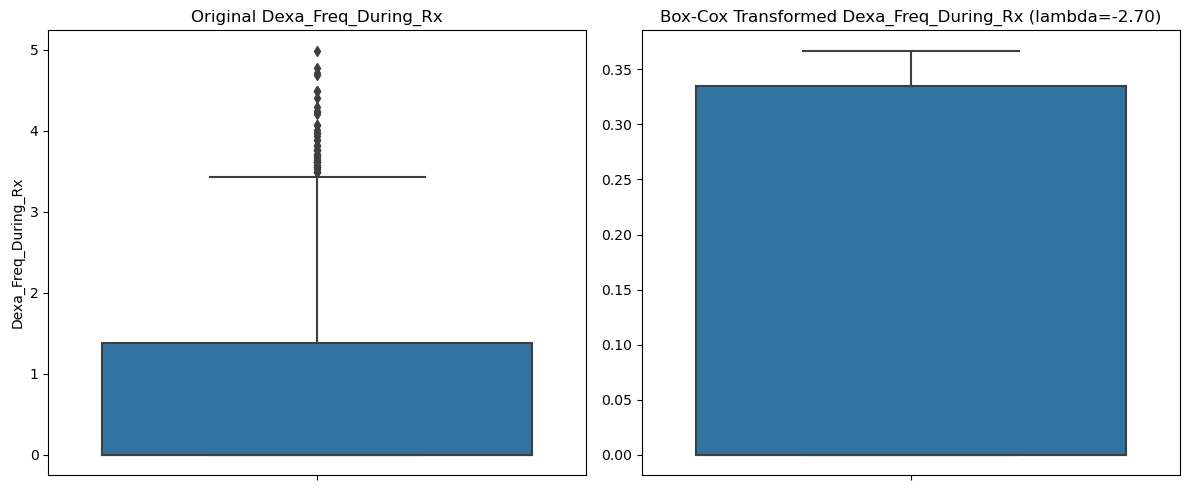

In [84]:
# Adding a constant to make 'Dexa_Freq_During_Rx' values positive

original_dexa_freq_during_rx = health_df['Dexa_Freq_During_Rx']

constant_value_dexa_freq_during_rx = 1  # Addin 1 to all values to make it greater than zero
positive_dexa_freq_during_rx = original_dexa_freq_during_rx + constant_value_dexa_freq_during_rx

# Applying the Box-Cox transformation for 'Dexa_Freq_During_Rx'
transformed_dexa_freq_during_rx, lambda_dexa_freq_during_rx = boxcox(positive_dexa_freq_during_rx)

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot for 'Dexa_Freq_During_Rx'
sns.boxplot(y=original_dexa_freq_during_rx, ax=axes[0])
axes[0].set_title('Original Dexa_Freq_During_Rx')

sns.boxplot(y=transformed_dexa_freq_during_rx, ax=axes[1])
axes[1].set_title(f'Box-Cox Transformed Dexa_Freq_During_Rx (lambda={lambda_dexa_freq_during_rx:.2f})')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [85]:
health_df[numerical_cols].describe()

,Dexa_Freq_During_Rx,Count_Of_Risks
count,3424.000000,3424.000000
mean,0.608034,0.685610
std,1.051456,0.499580
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.693147
75%,1.386294,1.098612
max,4.990433,2.079442


#### Handling class imbalance

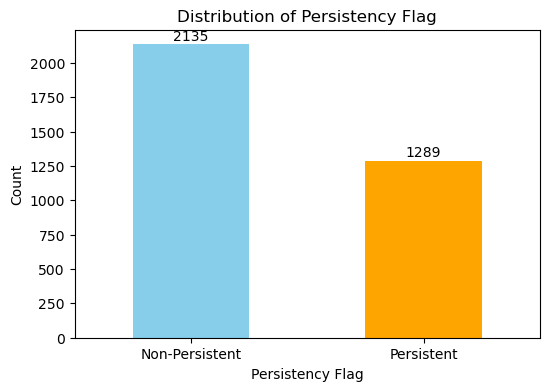

In [86]:
# Plotting the distribution of the target variable after upsampling

plt.figure(figsize=(6, 4))
ax = health_df['Persistency_Flag'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Persistency Flag')
plt.xlabel('Persistency Flag')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Adding count on each bar
for i, count in enumerate(health_df['Persistency_Flag'].value_counts()):
    ax.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()

Target class distribution after resampling:
Persistent        2135
Non-Persistent    2135
Name: Persistency_Flag, dtype: int64


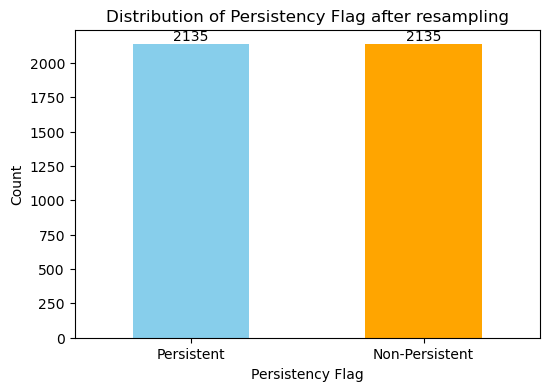

In [87]:
# Using the SMOTE techniques

from imblearn.over_sampling import SMOTE

# Separating the features and target variable
features = health_df.drop(columns=['Persistency_Flag'])

# Encoding the categorical columns
features = features.apply(LabelEncoder().fit_transform)  
target= health_df['Persistency_Flag'] 

# Using SMOTE to oversample the minority class
smote = SMOTE(random_state=27)
features_resampled, target_resampled = smote.fit_resample(features, target)

# Creating a DataFrame with the resampled data
resampled_df = pd.concat([pd.DataFrame(features_resampled, columns=features.columns), pd.DataFrame(target_resampled, columns=['Persistency_Flag'])], axis=1)

# Checking the class counts after resampling
print("Target class distribution after resampling:")
print(resampled_df['Persistency_Flag'].value_counts())

# Plotting the distribution of the target variable after resampling
plt.figure(figsize=(6, 4))
ax = resampled_df['Persistency_Flag'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Persistency Flag after resampling')
plt.xlabel('Persistency Flag')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Adding count on each bar
for i, count in enumerate(resampled_df['Persistency_Flag'].value_counts()):
    ax.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()


In [88]:
resampled_df.head()

,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,...,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Persistency_Flag
0,1,2,1,3,3,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Persistent
1,1,1,1,3,0,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Non-Persistent
2,0,2,0,0,1,5,0,1,0,0,...,1,0,0,0,0,0,0,0,2,Non-Persistent
3,0,2,1,0,3,5,0,1,0,1,...,0,0,0,0,0,0,0,0,1,Non-Persistent
4,0,2,1,0,3,5,0,1,1,1,...,0,0,0,0,0,0,0,0,1,Non-Persistent


In [90]:
#  Converting target variable to integers

resampled_df.Persistency_Flag = (resampled_df.Persistency_Flag == 'Persistent').astype(int)
resampled_df.Persistency_Flag

0       1
1       0
2       0
3       0
4       0
       ..
4265    1
4266    1
4267    1
4268    1
4269    1
Name: Persistency_Flag, Length: 4270, dtype: int32

In [91]:
resampled_df.head(2)

,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,...,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Persistency_Flag
0,1,2,1,3,3,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1,3,0,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
# Checking the features correlation

corr_matrix = resampled_df.corr()
print(corr_matrix['Persistency_Flag'].sort_values(ascending = False))


Persistency_Flag                                          1.000000
Dexa_During_Rx                                            0.472341
Dexa_Freq_During_Rx                                       0.356426
Comorb_Long_Term_Current_Drug_Therapy                     0.273703
Comorb_Encounter_For_Screening_For_Malignant_Neoplasms    0.269365
                                                            ...   
Risk_Excessive_Thinness                                  -0.065955
Frag_Frac_Prior_Ntm                                      -0.071617
Gluco_Record_Prior_Ntm                                   -0.077648
Risk_Poor_Health_Frailty                                 -0.083327
Ntm_Speciality_Bucket                                    -0.119238
Name: Persistency_Flag, Length: 68, dtype: float64


In [25]:
corr_matrix1  = resampled_df.corr()
corr_matrix1

,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,...,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Persistency_Flag
Gender,1.000000,0.015629,0.012455,0.018378,0.079082,0.034395,0.010317,-0.012545,0.035312,-0.005264,...,-0.022619,-0.025887,0.014088,0.007686,-0.025088,-0.011266,0.006675,0.041210,0.011659,-0.037685
Race,0.015629,1.000000,-0.012016,-0.049633,0.017899,-0.002503,-0.003415,0.002755,0.049623,0.045136,...,0.003343,-0.031601,0.012232,-0.003588,0.007799,0.011586,0.013075,0.003030,-0.007450,0.004023
Ethnicity,0.012455,-0.012016,1.000000,-0.116749,0.016160,0.027792,-0.044347,0.048392,0.030503,0.018331,...,-0.009615,-0.010082,-0.013970,-0.044798,-0.005035,0.008862,0.010001,0.022511,-0.042707,0.008303
Region,0.018378,-0.049633,-0.116749,1.000000,0.008651,-0.086564,-0.004555,-0.067828,-0.031751,-0.020811,...,-0.041696,0.086694,-0.006070,0.015876,0.025145,-0.031047,-0.019127,-0.006943,0.090002,0.063781
Age_Bucket,0.079082,0.017899,0.016160,0.008651,1.000000,-0.055282,-0.082246,0.003990,0.036995,0.014416,...,-0.039800,0.005010,0.044518,0.011200,-0.028065,-0.000046,0.030315,0.051695,-0.026480,-0.032080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Risk_Estrogen_Deficiency,-0.011266,0.011586,0.008862,-0.031047,-0.000046,0.034650,0.022057,-0.017514,-0.002993,-0.009102,...,-0.005186,-0.010151,-0.011236,-0.006417,-0.005752,1.000000,-0.002915,-0.006561,0.072535,-0.023100
Risk_Immobilization,0.006675,0.013075,0.010001,-0.019127,0.030315,0.025941,-0.015828,0.004891,0.001230,-0.006029,...,-0.005852,-0.020418,0.259410,-0.007241,0.030171,-0.002915,1.000000,0.024857,0.092566,-0.057354
Risk_Recurring_Falls,0.041210,0.003030,0.022511,-0.006943,0.051695,0.018737,0.016651,0.008102,0.007331,0.007440,...,0.005090,0.024314,0.050201,0.087581,0.001894,-0.006561,0.024857,1.000000,0.177573,-0.047951
Count_Of_Risks,0.011659,-0.007450,-0.042707,0.090002,-0.026480,0.031995,0.126081,-0.017633,0.129879,0.137888,...,0.145635,0.565605,0.277716,0.175437,0.133788,0.072535,0.092566,0.177573,1.000000,0.017375


In [26]:
# Numerical features' correlation
numerical_features = ['Dexa_Freq_During_Rx', 'Count_Of_Risks']  
for feature in numerical_features:
    print(f"Correlation between {feature} and Persistency_Flag: {corr_matrix.at[feature, 'Persistency_Flag']}")
    

Correlation between Dexa_Freq_During_Rx and Persistency_Flag: 0.3564256998874984
Correlation between Count_Of_Risks and Persistency_Flag: 0.017375338852445615


#### Feature selection using Recursive Feature Elimination (RFE) method


In [27]:

# Sepeating the resampled dataframe
X = resampled_df.drop(['Persistency_Flag'], axis=1)
y = resampled_df['Persistency_Flag']

# Initializing the model
model = RandomForestClassifier()

# Creating the RFE object and rank each feature
rfe = RFE(model, n_features_to_select=20) # Selecting 20 most ranked features
rfe = rfe.fit(X, y)

# Getting the names of the selected features
selected_feature_names = X.columns[rfe.support_]

print("Selected features:", selected_feature_names)

# Evaluating the performance using cross-validation

# Transforming the features
X_rfe = rfe.transform(X)  
scores = cross_val_score(model, X_rfe, y, cv=5)  # 5-fold cross-validation

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


Selected features: Index(['Region', 'Age_Bucket', 'Ntm_Speciality', 'Ntm_Speciality_Bucket',
       'Dexa_Freq_During_Rx', 'Dexa_During_Rx', 'Tscore_Bucket_Prior_Ntm',
       'Risk_Segment_During_Rx', 'Idn_Indicator',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency', 'Comorb_Long_Term_Current_Drug_Therapy',
       'Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias',
       'Concom_Cholesterol_And_Triglyceride_Regulating_Preparations',
       'Concom_Narcotics', 'Concom_Systemic_Corticosteroids_Plain',
       'Concom_Anti_Depressants_And_Mood_Stabilisers', 'Count_Of_Risks'],
      dtype='object')
Cross-validation scores: [0.79742389 0.78688525 0.74941452 0.74473068 0.78688525]
Mean cross-validation score: 0.7730679156908665


In [87]:
# Creating the RFE object and rank each feature
rfe = RFE(model, n_features_to_select=30) # Selecting 30 most ranked features
rfe = rfe.fit(X, y)

# Getting the names of the selected features
selected_feature_names = X.columns[rfe.support_]

print("Selected features:", selected_feature_names)

# Evaluating the performance using cross-validation

# Transforming the features
X_rfe = rfe.transform(X)  
scores = cross_val_score(model, X_rfe, y, cv=5)  # 5-fold cross-validation

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Selected features: Index(['Region', 'Age_Bucket', 'Ntm_Speciality', 'Ntm_Speciality_Bucket',
       'Gluco_Record_Prior_Ntm', 'Dexa_Freq_During_Rx', 'Dexa_During_Rx',
       'Frag_Frac_Prior_Ntm', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx', 'Idn_Indicator',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy',
       'Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias',
       'Comorb_Osteoporosis_without_current_pathological_fracture',
       'Comorb_Gastro_esophageal_reflux_disease',
       'Concom_Cholesterol_And_Triglyceride_Regulating_Preparations',
       'Concom_Narcotics', 'C

In [88]:

# Creating the RFE object and rank each feature
rfe = RFE(model, n_features_to_select=40)
rfe = rfe.fit(X, y)

# Getting the names of the selected features
selected_feature_names = X.columns[rfe.support_]

print("Selected features:", selected_feature_names)

# Evaluating the performance using cross-validation

# Transform the dataset
X_rfe = rfe.transform(X) 
scores = cross_val_score(model, X_rfe, y, cv=5)  # 5-fold cross-validation

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


Selected features: Index(['Region', 'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag',
       'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm',
       'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Dexa_During_Rx',
       'Frag_Frac_Prior_Ntm', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Idn_Indicator',
       'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Comorb_Personal_History_Of_Other_Diseases_And_Conditions',
       'Comorb_Other_Disorders_Of_Bone_Density_And_Str

In [89]:
# Creating the RFE object and rank each feature
rfe = RFE(model, n_features_to_select=50)
rfe = rfe.fit(X, y)

# Getting the names of the selected features
selected_feature_names = X.columns[rfe.support_]

print("Selected features:", selected_feature_names)

# Evaluating the performance using cross-validation

# Transform the dataset
X_rfe = rfe.transform(X) 
scores = cross_val_score(model, X_rfe, y, cv=5)  # 5-fold cross-validation

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


Selected features: Index(['Race', 'Region', 'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag',
       'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm',
       'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Dexa_During_Rx',
       'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Adherent_Flag',
       'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Comorb_Personal_History_Of_Other_Diseases_And_Conditions',
      

In [90]:
# Creating the RFE object and rank each feature
rfe = RFE(model, n_features_to_select=55)
rfe = rfe.fit(X, y)

# Getting the names of the selected features
selected_feature_names = X.columns[rfe.support_]

print("Selected features:", selected_feature_names)

# Evaluating the performance using cross-validation

# Transform the dataset
X_rfe = rfe.transform(X) 
scores = cross_val_score(model, X_rfe, y, cv=5)  # 5-fold cross-validation

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


Selected features: Index(['Gender', 'Race', 'Region', 'Age_Bucket', 'Ntm_Speciality',
       'Ntm_Specialist_Flag', 'Ntm_Speciality_Bucket',
       'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx',
       'Dexa_Freq_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm',
       'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Comorb_Personal_History_O

The model with 50 features appears to be ideal as the differences in validation scores with the lesser features is slightly significant.

### Model building

#### Using a linear model - Logistic Regression Classifier

Accuracy of Logistic Regression on training set: 0.79
Accuracy of Logistic Regression on test set: 0.78
Logistic Regression Training Time (seconds): 0.9706211090087891

Predicted flag: [1 0 0 0 0 1 0 0 0 0]

Confusion Matrix:
[[549  99]
 [110 523]]


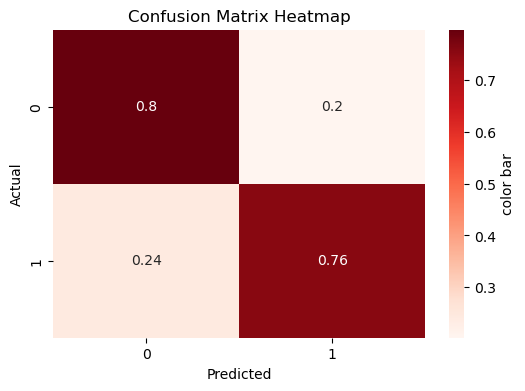


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       648
           1       0.79      0.76      0.77       633

    accuracy                           0.78      1281
   macro avg       0.78      0.78      0.78      1281
weighted avg       0.78      0.78      0.78      1281


Accuracy Score:
77.75

Cross-validation scores: [0.78220141 0.81030445 0.74004684 0.74941452 0.77985948 0.71896956
 0.70257611 0.76346604 0.735363   0.76814988]
Mean cross-validation score: 75.5


In [62]:



# Create a pipeline with scaling and RFE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling the features
    ('rfe', RFE(estimator=LogisticRegression(), n_features_to_select=50)), # Using 50 top features
    ('classifier', LogisticRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the start time of the training
start_time = time.time()

# Fit the pipeline to the training data
log_reg_model = pipeline.fit(X_train, y_train)
log_reg_time = time.time() - start_time

# Print training and testing accuracy
print('Accuracy of Logistic Regression on training set: {:.2f}'.format(log_reg_model.score(X_train, y_train)))
print('Accuracy of Logistic Regression on test set: {:.2f}'.format(log_reg_model.score(X_test, y_test)))
print('Logistic Regression Training Time (seconds):', log_reg_time)

# Predict on the test set
y_pred = log_reg_model.predict(X_test)
print("\nPredicted flag:",y_pred[:10])

# Get the confusion matrix
print("\nConfusion Matrix:")
log_reg_matrix = confusion_matrix(y_test, y_pred)
print(rf_matrix)

# Normalize the confusion matrix
log_reg_matrixN = confusion_matrix(y_test, y_pred, normalize='true')

# Plot the confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(log_reg_matrixN, cmap="Reds", annot=True, cbar_kws={"orientation": "vertical", "label": "color bar"})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Get the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Check the model accuracy score
print("\nAccuracy Score:")
print(round(accuracy_score(y_test, y_pred)*100, 2))

# Cross-validation to further validate the model
cv_scores = cross_val_score(pipeline, X, y, cv=10)
print("\nCross-validation scores:", cv_scores)
print("Mean cross-validation score:", round(cv_scores.mean()*100, 2))


#### Using an Ensemble model  -  Random Forest Classifier

Accuracy of Random Forest classifier on training set: 1.00
Accuracy of Random Forest classifier on test set: 0.84
Random Forest classifier Training Time (seconds): 16.097429513931274

Predicted flag: [1 1 0 0 0 1 0 0 0 0]

Confusion Matrix:
[[549  99]
 [110 523]]


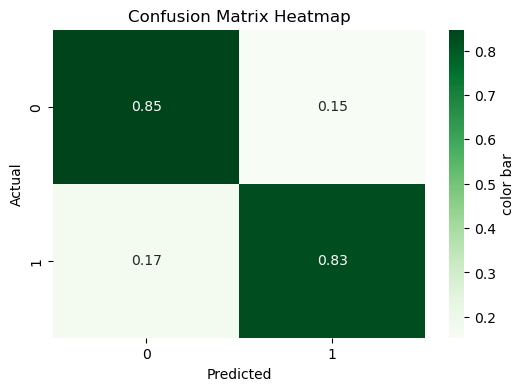


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       648
           1       0.84      0.83      0.83       633

    accuracy                           0.84      1281
   macro avg       0.84      0.84      0.84      1281
weighted avg       0.84      0.84      0.84      1281


Accuracy Score:
83.68

Cross-validation scores: [0.81967213 0.82903981 0.81733021 0.80796253 0.81264637 0.78454333
 0.80562061 0.80093677 0.81264637 0.82435597]
Mean cross-validation score: 81.15


In [44]:
# Creating a pipeline with scaling and selecting features using Recursive Feature Elemination method

pipeline = Pipeline([
    ('scaler', StandardScaler()), # Scaling the features
    ('rfe', RFE(estimator=RandomForestClassifier(), n_features_to_select=50)), # Using 50 top features
    ('classifier', RandomForestClassifier())
])

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

 #initializing the start time of the trainning
start_time = time.time() 

# Fiting the pipeline to the training data
rf_model = pipeline.fit(X_train, y_train)
rf_time = time.time() - start_time
print('Accuracy of Random Forest classifier on training set: {:.2f}'.format(rf_model.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf_model.score(X_test, y_test)))
print('Random Forest classifier Training Time (seconds):',rf_time)

# Predicting the test set
y_pred = rf_model.predict(X_test)
print("\nPredicted flag:",y_pred[:10])

# Getting the model confusion matrix
print("\nConfusion Matrix:")
rf_matrix = confusion_matrix(y_test, y_pred)
print(rf_matrix)

# Normalizing the confusion matrix
rf_matrixN = confusion_matrix(y_test, y_pred, normalize='true')

# Heat map for the model confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(rf_matrixN, cmap="Greens", annot=True, cbar_kws={"orientation":"vertical", "label":"color bar"})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Getting the model classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Checking the model accuracy score
print("\nAccuracy Score:")
print(round(accuracy_score(y_test, y_pred)*100, 2))

# Cross-validation to further validate the model
cv_scores = cross_val_score(pipeline, X, y, cv=10)
print("\nCross-validation scores:", cv_scores)
print("Mean cross-validation score:", round(cv_scores.mean()*100, 2))

#### Using an XG Boosting classifer

Accuracy of XGBoost classifier on training set: 0.98
Accuracy of XGBoost classifier on test set: 0.82
XGBoost classifier Training Time (seconds): 2.7726051807403564

Predicted flag: [1 1 0 0 0 1 0 0 0 0]

Confusion Matrix:
[[549  99]
 [110 523]]


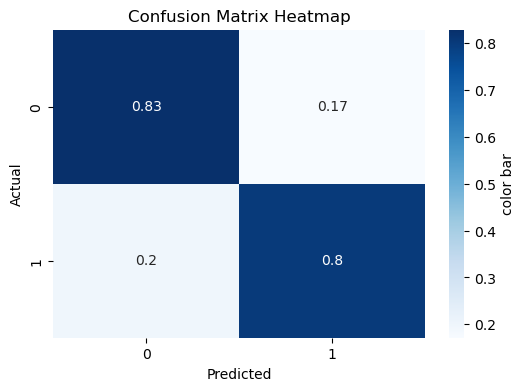


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       648
           1       0.82      0.80      0.81       633

    accuracy                           0.82      1281
   macro avg       0.82      0.82      0.82      1281
weighted avg       0.82      0.82      0.82      1281


Accuracy Score:
81.58

Cross-validation scores: [0.82669789 0.79859485 0.75644028 0.73302108 0.78922717 0.73067916
 0.75175644 0.78220141 0.7704918  0.77985948]
Mean cross-validation score: 77.19


In [93]:
#  Using XGBoost classifier to select featues and tain the classification model

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling the features
    ('rfe', RFE(estimator=XGBClassifier(), n_features_to_select=50)), # Using 50 top features
    ('classifier', XGBClassifier())
])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initializing the start time of the training
start_time = time.time() 

# Fitting the pipeline to the training data
xgb_model = pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

# Evaluating the model
train_accuracy = xgb_model.score(X_train, y_train)
test_accuracy = xgb_model.score(X_test, y_test)

print('Accuracy of XGBoost classifier on training set: {:.2f}'.format(train_accuracy))
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(test_accuracy))
print('XGBoost classifier Training Time (seconds):', training_time)

# Predicting the test set
y_pred = xgb_model.predict(X_test)
print("\nPredicted flag:", y_pred[:10])

# Getting the model confusion matrix
print("\nConfusion Matrix:")
xgb_matrix = confusion_matrix(y_test, y_pred)
print(rf_matrix)

# Normalizing the confusion matrix
xgb_matrixN = confusion_matrix(y_test, y_pred, normalize='true')

# Heat map for the model confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(xgb_matrixN, cmap="Blues", annot=True, cbar_kws={"orientation":"vertical", "label":"color bar"})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Getting the model classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Checking the model accuracy score
print("\nAccuracy Score:")
print(round(accuracy_score(y_test, y_pred)*100, 2))

# Cross-validation to further validate the model
cv_scores = cross_val_score(pipeline, X, y, cv=10)
print("\nCross-validation scores:", cv_scores)
print("Mean cross-validation score:", round(cv_scores.mean()*100, 2))

Model           Accuracy

Linear model     77.75%,
Ensemble model   83.63% and 
Boosting model   81.58%.

The ensemble model outperformed the other two models and is considered more suitable for the prediction of the persistency_flag due to is high accuracy with good balance between precision and recall,indicating it is reliable in both identifying positive cases and avoiding false positives. Therefore, this suggests that the model performs reasonably well.